In [131]:
#Imports
from xgboost import XGBClassifier
import sys
sys.path.append('../scripts')
import evaluation_utils as eval_utils
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [132]:

import os
import pandas as pd
from detect_congestion_events import detect_congestion_events

base_dir = '../data_processed'
all_data = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.csv'):
            path = os.path.join(root, file)
            df = pd.read_csv(path)
            df['variant'] = os.path.basename(root)  #  añadir columna con el nombre de la variante
            all_data.append(df)

# Concatenar todos los DataFrames
df_all = pd.concat(all_data, ignore_index=True)

print(f"Cantidad de registros: {df_all.shape[0]}")


Cantidad de registros: 3086164


In [133]:
# Etiquetar eventos de congestión.
df_all['congestion_event'] = detect_congestion_events(df_all)

df_all.dropna(inplace=True)

In [134]:

# Seleccionar features y target

features = ['cwnd', 'rtt', 'bytes_retrans', 'bytes_acked', 'throughput', 'packets_lost']
df_all = df_all.dropna(subset=features + ['congestion_event'])

X = df_all[features]
y = df_all['congestion_event']

In [135]:
# Buscamos: 80 % entrenamiento, 10% validación, 10% prueba

# División inicial: 80% entrenamiento, 20% para validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# División 50% para validación, 50% para prueba sobre el 20% anterior
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [136]:
#Escalar los datos con z-score normalization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [137]:
#Entrenar modelo

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

xgb_model.fit(X_train_scaled, y_train)



,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


c:\Users\ian\Desktop\fing\tesis\Machine-Learning-CC\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:04:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Threshold óptimo (balanced): 0.998

=== EVALUACIÓN EN TEST SET ===
              precision    recall  f1-score   support

           0       0.87      0.89      0.88    219450
           1       0.70      0.66      0.68     89167

    accuracy                           0.82    308617
   macro avg       0.79      0.78      0.78    308617
weighted avg       0.82      0.82      0.82    308617


Métricas adicionales:
Balanced Accuracy: 0.775
Matthews Correlation Coefficient: 0.561


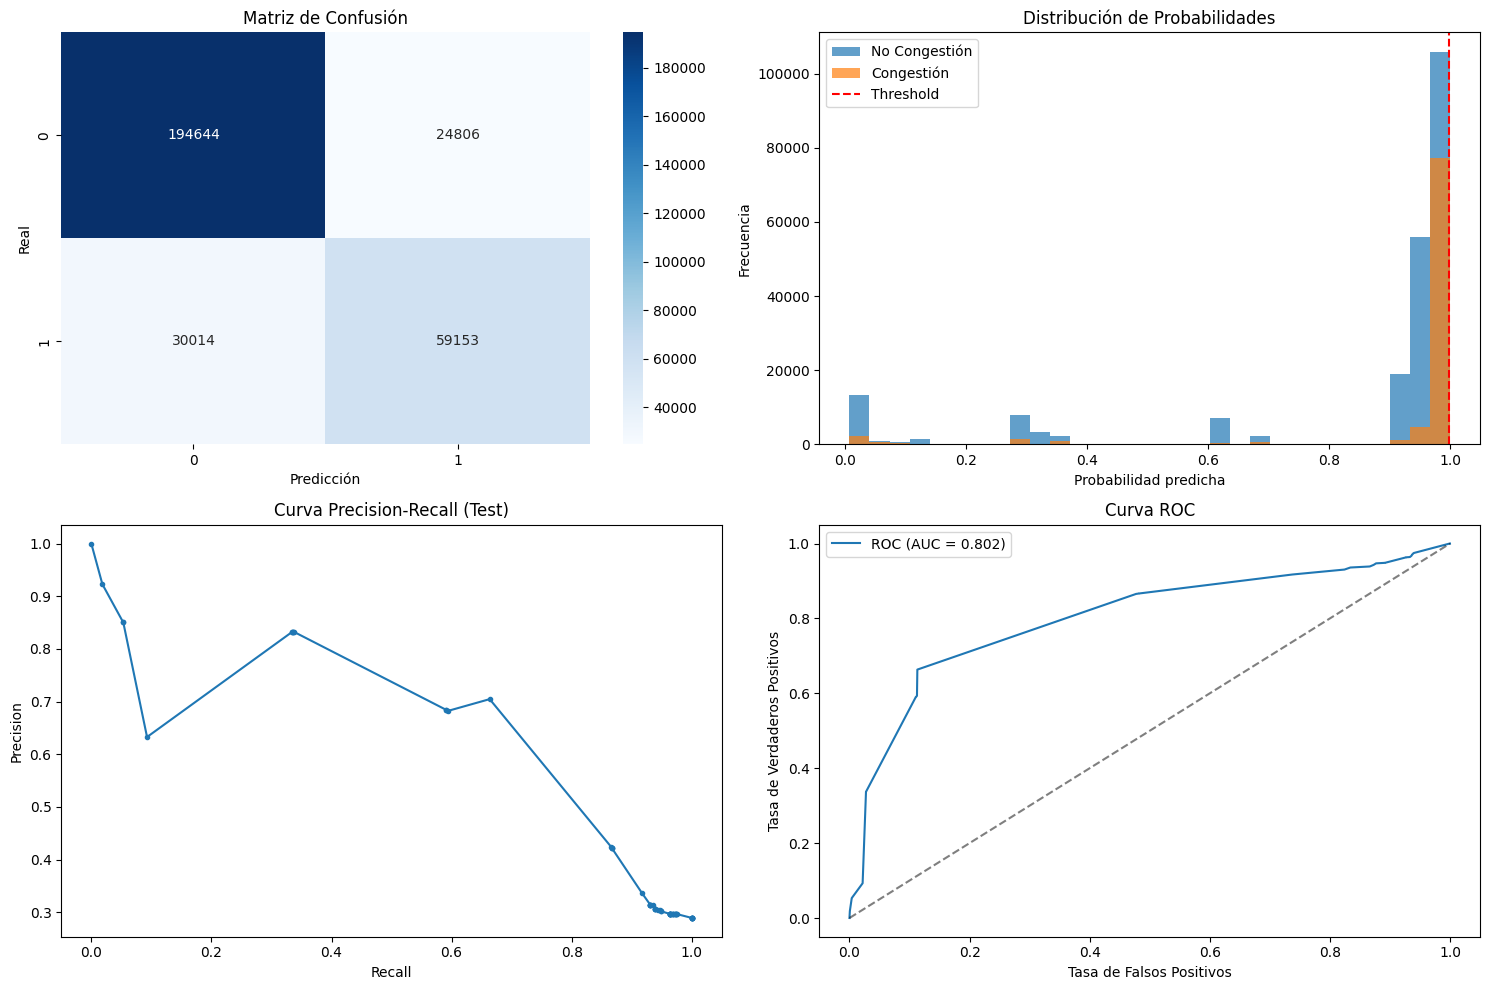


=== ANÁLISIS DE SENSIBILIDAD ===
Threshold 0.948: F1 = 0.491
Threshold 0.998: F1 = 0.683
Threshold 1.000: F1 = 0.000


In [138]:

#Evaluar modelo

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

y_pred, best_threshold, metrics = eval_utils.comprehensive_evaluation(
    model=model,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, 
    X_test=X_test, y_test=y_test,
    plot=True
)


 Threshold óptimo (max F1-score): 0.37

 Reporte de clasificación (threshold ajustado):
              precision    recall  f1-score   support

           0       0.92      0.91      0.91    219450
           1       0.78      0.81      0.79     89167

    accuracy                           0.88    308617
   macro avg       0.85      0.86      0.85    308617
weighted avg       0.88      0.88      0.88    308617



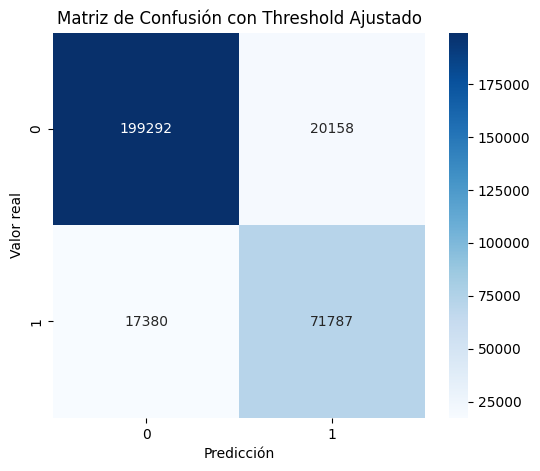

In [139]:
y_pred_adjusted, best_threshold = eval_utils.evaluate_with_optimal_threshold(model, X_test_scaled, y_test)